# Configuration
Install and import services.

In [1]:
# General purpose modules
import time
import sys
import os

#Read csv files adn plots
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import ast

#Retrieval from twitter
import tweepy
from getpass import getpass

#Tweet preprocessing tasks
!pip install emoji
!pip install pyspellchecker
import re
import emoji
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

#random numbers
from random import randint

# Progress bar utility
def initialize_progress_bar():
  # setup progressbar
  toolbar_width = 40
  sys.stdout.write("[%s]" % (" " * toolbar_width))
  sys.stdout.flush()
  sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['

def manage_progress_bar(j):
  if (j == 0): sys.stdout.write(" " * 4)
  j += 1
  n = 5
  if (len(str(j*100//40)) < 2): n = 4
  sys.stdout.write("\b" * n)
  sys.stdout.write("- %s" % (str(j*100//40)))
  sys.stdout.write("%]")
  sys.stdout.flush()
  if (j == 40): sys.stdout.write("\n") # end the progress bar
  return j

#Access to Google drive file system
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=aed4ef0bb8754ed339bf3cb6f73fbf72362e8e2e8e9c1ef30df14e2b1b7da8be
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     |████████████████████████████████| 1.9MB 4.6MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
·····

## Load files in primary storage

In [2]:
kbase = pd.read_csv('Datasets/WIR_P12/dbpedia-classes/DBP_wiki_data_notext_nocomma.csv')
kbase.columns

Index(['Unnamed: 0', 'l1', 'l2', 'l3', 'wiki_name'], dtype='object')

## Knowledge Base Distribution

In [3]:
def count_occurrences(level):

    categories = kbase[level]

    category_info_dict = {}

    for cat in categories:
        if cat in category_info_dict:
            category_info_dict[cat] += 1
        else:
            category_info_dict[cat] = 0
    return category_info_dict

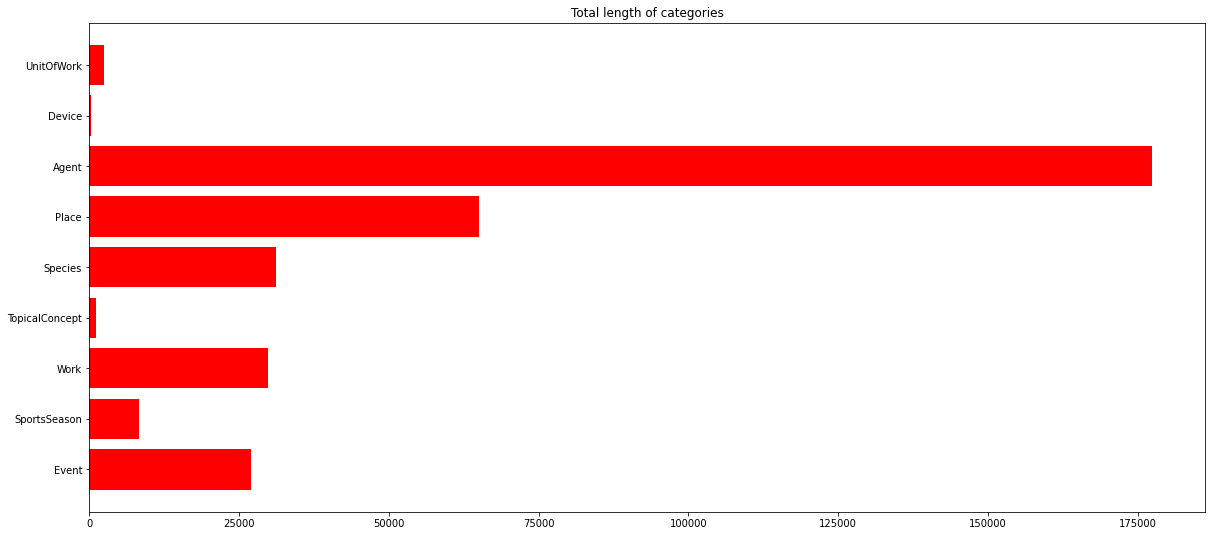

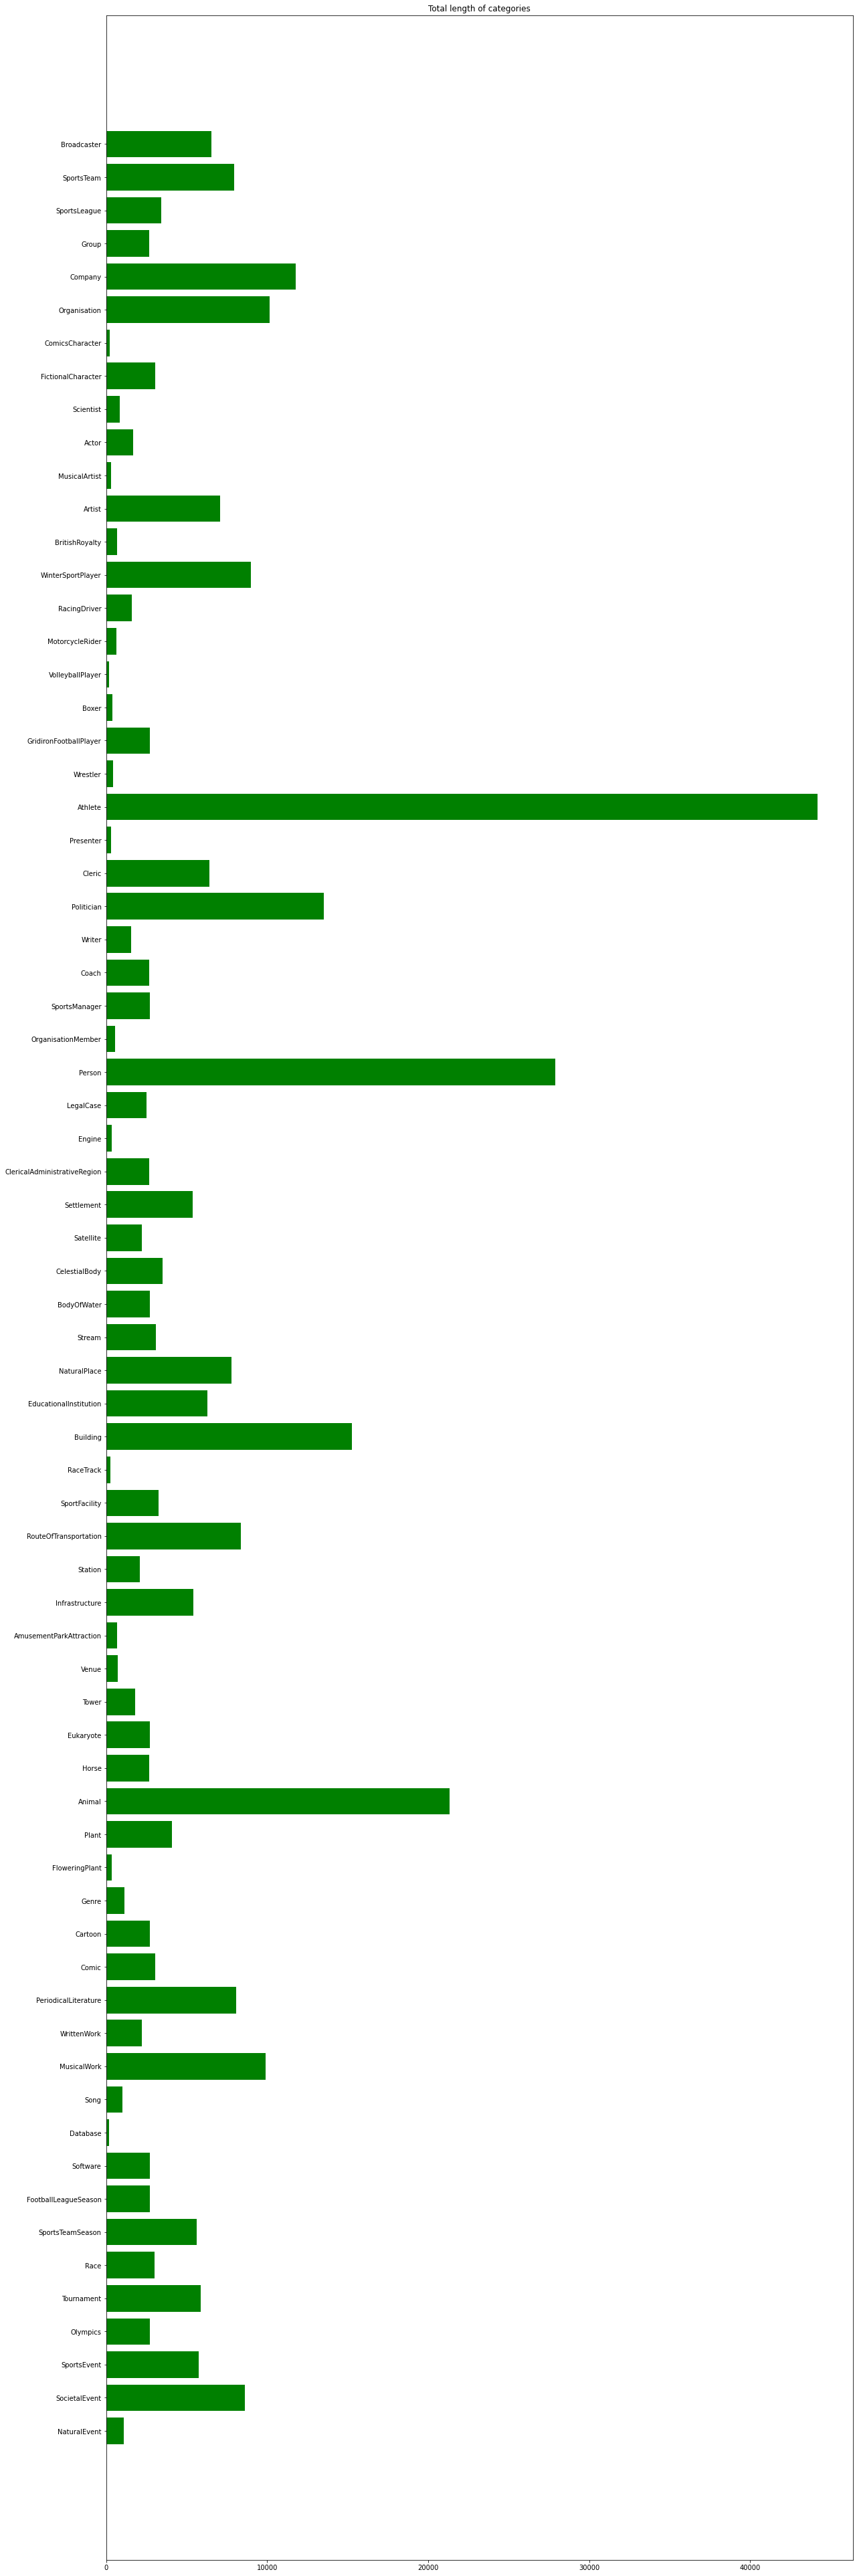

TOP 23 CATEGORIES IN THE KB:
Athlete: 44162 pages
Person: 27891 pages
Animal: 21332 pages
Building: 15265 pages
Politician: 13513 pages
Company: 11776 pages
Organisation: 10136 pages
MusicalWork: 9902 pages
WinterSportPlayer: 8971 pages
SocietalEvent: 8607 pages
RouteOfTransportation: 8358 pages
PeriodicalLiterature: 8088 pages
SportsTeam: 7967 pages
NaturalPlace: 7765 pages
Artist: 7090 pages
Broadcaster: 6548 pages
Cleric: 6419 pages
EducationalInstitution: 6305 pages
Tournament: 5881 pages
SportsEvent: 5765 pages
SportsTeamSeason: 5608 pages
Infrastructure: 5396 pages
Settlement: 5386 pages


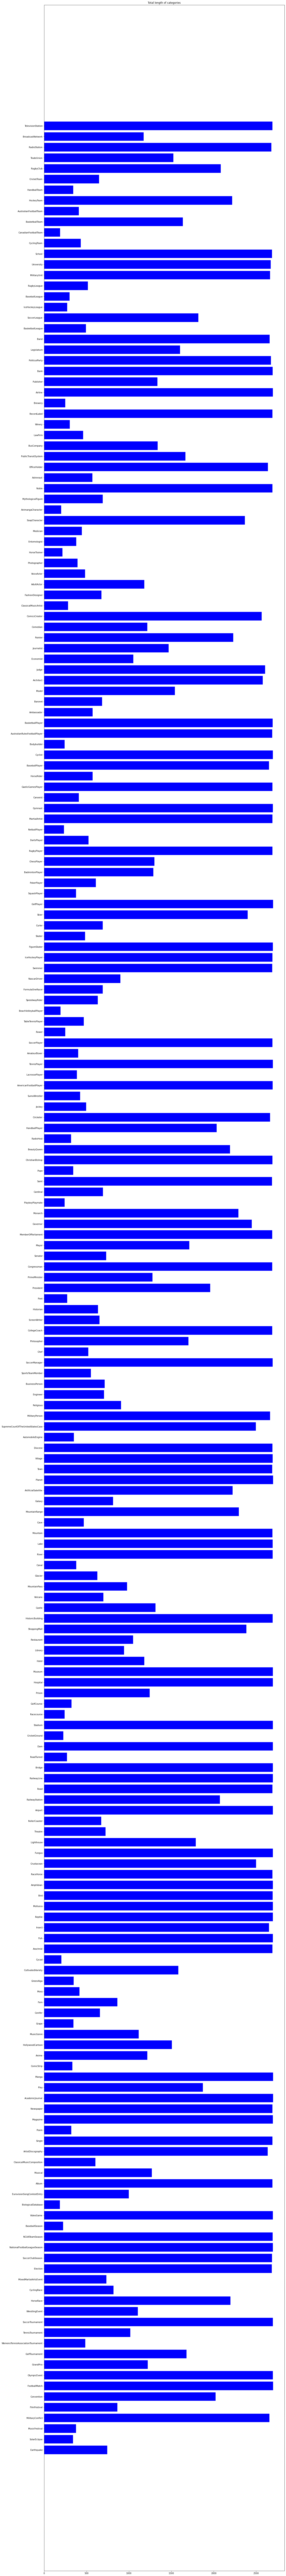

In [4]:
%matplotlib inline

def plot_kb_distr(level):

    category_info_dict = count_occurrences(level)

    labels = list(category_info_dict.keys())
    values = list(category_info_dict.values())

    plt.figure(figsize=(20,len(values)))
    plt.title('Total length of categories')
    
    cmap = {'l1': 'r', 'l2':'g', 'l3': 'b'}

    for i, cat in enumerate(category_info_dict):
        plt.barh(labels, values, color=cmap[level])

    plt.show()

    sorted_categories = sorted(category_info_dict.items(), key=lambda x: x[1], reverse=True)

    if level == 'l2':
        print('TOP 23 CATEGORIES IN THE KB:')
        for cat, value in sorted_categories[:23]:
            print('{}: {} pages'.format(cat, value))
            
plot_kb_distr('l1')
plot_kb_distr('l2')
plot_kb_distr('l3')

# Tweets dataset

## Authentication via Twitter App
1. Provide the keys of your twitter app.
2. Establish an authenticated session with the Standard Twitter API through the tweepy library.

In [ ]:
consumer_key = getpass('Enter consumer_key here')
consumer_secret = getpass('Enter consumer_secret here')
access_token = getpass('Enter access_token here')
access_token_secret = getpass('Enter access_token_secret here')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

## Collect Tweets
Collect tweets through the Twitter session.

In [ ]:
def query_twitter(query):
    api = tweepy.API(auth)
    max_tweets = 5
    public_tweets = [status for status in tweepy.Cursor(api.search, q=query, lang='en', tweet_mode='extended').items(max_tweets)]
    i = 0

    for tweet in public_tweets:
        print(str(i) + ': ' + tweet.full_text)
        dictionary['tweets'].append(tweet.full_text)
        print('-------------------------------------------------------------------')
        i = i+1

#Examples of queries submitted to the twitter API
dictionary = {'tweets':[]}
query_twitter('National Geographic')
query_twitter('People Magazine')
query_twitter('Family Circle')
query_twitter('Game Informer Magazine')

#Create a Pandas dataframe and write it on a .csv file
dataframe = pd.DataFrame(dictionary)
dataframe.to_csv('tweets/periodical_literature.csv')
    

# Implementation of the system

## Preprocess tweet
* method to preprocess the tweet:
    * input: raw tweet
    * output: list of tokens extracted from the raw tweet

In [ ]:
def tweet_preprocessing(tweet):
  #remove RT
  tweet = re.sub(r'RT', '', tweet)
  #remove urls from the tweet
  tweet = re.sub(r'http\S+', '', tweet)
  #remove ats, hashtags and emails
  tweet = re.sub(r'[^\s]+@[^\s]+', '', tweet)
  tweet = re.sub(r'@', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  #remove emojis, symbols and flags
  tweet = emoji.get_emoji_regexp().sub(u'', tweet)
  #tokenize tweet
  tweet = word_tokenize(tweet)
  return tweet

## Build prefix map
* This code snippet creates a prefix map over the entries of the *DBP_wiki_data_notext_nocomma.csv* knowledge base.
* The prefix map is kept in main memory under the *prefix_map* variable.


In [ ]:
# entity_list is simply a list of wiki_names like "Cristiano_Ronaldo"
def prefix_map_add_batch(entity_list):
  size = len(entity_list)
  if (size>40):
    initialize_progress_bar()
  i_prog = j_prog = 0  # progress bar variables

  for entry in entity_list:  # entry i.e. each wiki_name
    i_prog += 1
    prefix = ''
    for token in word_tokenize(entry.replace('_', ' ')):
      prefix = (prefix + ' ' + token).strip()  # update prefix
      
      kb_node = None
      stop = False
      if prefix == entry.replace('_', ' '):  # if prefix == entry
        kb_node = entry  # set the kb_node
        stop = True

      try:
        # check if the prefix is already in the map
        found = False
        for i in range(len(prefix_map[hash(prefix)])):
          # if it is already contained
          if prefix == prefix_map[hash(prefix)][i][0]:
            found = True
            # if we are not done with the current entry, set stop=False for the map entry
            # otherwise, leave it unchanged
            if not stop:
              prefix_map[hash(prefix)][i][2] = False
            else:
              prefix_map[hash(prefix)][i][1] = kb_node
            break
        # if it is not, append it
        if not found:
          prefix_map[hash(prefix)].append([prefix, kb_node, stop])
      except KeyError:
        prefix_map[hash(prefix)] = [[prefix, kb_node, stop]]
    # Managing the progress bar
    if (size > 40 and i_prog % (size//40) == 0):
      j_prog = manage_progress_bar(j_prog)

prefix_map = {}
prefix_map_add_batch(kbase['wiki_name'])

[                                        ]    - 2%]- 5%]- 7%]- 10%]- 12%]- 15%]- 17%]- 20%]- 22%]- 25%]- 27%]- 30%]- 32%]- 35%]- 37%]- 40%]- 42%]- 45%]- 47%]- 50%]- 52%]- 55%]- 57%]- 60%]- 62%]- 65%]- 67%]- 70%]- 72%]- 75%]- 77%]- 80%]- 82%]- 85%]- 87%]- 90%]- 92%]- 95%]- 97%]- 100%]


## Build the Inverted Index
Create an inverted index that, given a *wiki_name*, returns the corresponding lineage [l1,l2,l3].

In [ ]:
initialize_progress_bar()

inv_index = {}
i = j = 0 # parameters for the progress bar
for index, row in kbase.iterrows():
  i += 1
  inv_index[row['wiki_name']] = [row['l1'], row['l2'], row['l3']]

  # Managing the progress bar
  if (i % (len(kbase)//40) == 0):
    j = manage_progress_bar(j)

[                                        ]    - 2%]- 5%]- 7%]- 10%]- 12%]- 15%]- 17%]- 20%]- 22%]- 25%]- 27%]- 30%]- 32%]- 35%]- 37%]- 40%]- 42%]- 45%]- 47%]- 50%]- 52%]- 55%]- 57%]- 60%]- 62%]- 65%]- 67%]- 70%]- 72%]- 75%]- 77%]- 80%]- 82%]- 85%]- 87%]- 90%]- 92%]- 95%]- 97%]- 100%]


## Extract Mentions
* This cell contains a function that has the role to search formentions in a given list of tweets
* This search exploits the prefix map, in order to search efficiently in the knowledge base

In [ ]:
def extract_mentions(tweets):
  tweets_mentions = []
  #scan all the tweets in the dataset
  for tokens in tweets:
    #list of mentions for the current tweet
    mentions = []
    for i in range(len(tokens)):
      token = tokens[i]
      #if the token is in the kb
      try:
        #True if you have found a mention
        done = False
        #scan consecutive tokens in the tweet
        j = 1;
        while (i+j) <= len(tokens):
          #Keep track of the last kb node found
          last_kb_node = None
          #compute the hash for the selected tokens
          prefix_map_list = prefix_map[hash(token)]
          #scan the adjacency list of the HashMap
          for prefix_map_token in prefix_map_list:
            #take the entry that you need from the adjacency list
            if prefix_map_token[0].lower() == token.lower():
              #stop is true, return what you have
              if prefix_map_token[2] == True:
                last_kb_node = prefix_map_token[1]
                mentions.append(last_kb_node)
                done = True
              #stop is false
              else:
                if prefix_map_token[1] != None:
                    last_kb_node = prefix_map_token[1]
                if i+j != len(tokens):
                  token = token + ' ' + tokens[i+j]
                  j += 1
                else:
                  j += 1
          #Found a mention
          if done == True:
              next_token = True
              break

        if last_kb_node != None:
            mentions.append(last_kb_node)
      except KeyError:
          pass
    #Add the final mentions for this tweet to a global list
    tweets_mentions.append(mentions)
  return tweets_mentions

## Classifying and Tagging the Tweet
Dopo aver estratto le mentions di un tweet dalla prefix map, posso procedere alla classificazione.

```
# INPUT(mentions) // we refer to the mentions of the tweet to be classified
# OUTPUT(class_l2)
```

For each mention (m1, n1, s1):
* Starting at n1, we go up all lineages of n1, all the way to the root, and assign to each node in these lineages a score (currently set to be s1, the same score as that of n1).
* If we find two partially overlapping lineages, the common nodes in the *kbase* should get an increased score. Start with s1+s2, later on we can refine this score.
* Let C be the decreasingly ordered list of all scored nodes in all lineages. **Select from C all topic nodes**. Starting from C we can both produce a classification (pick the highest) and a tagging (pick all).



## Taxonomic score (struct)
Produce a scoring data structure with:
*   the shape of the taxonomic hierarchy
*   an additional field **score**, as a placeholder of the score of that category.
```
## INPUT (./dbpedia-classes/taxonomy.txt)
```


In [ ]:
def create_tax_score():
  tax_file = open("Datasets/WIR_P12/dbpedia-classes/taxonomy.txt", "r")
  tax_score = {}

  for line in tax_file:
    if (not line[0]=='\t'):
      l1 = word_tokenize(line)[0]
      tax_score[l1] = {}
      tax_score[l1]['score'] = 0
    else:
      if (not line[1]=='\t'):
        l2 = word_tokenize(line)[0]
        tax_score[l1][l2] = {}
        tax_score[l1][l2]['score'] = 0
      else:
        l3 = word_tokenize(line)[0]
        tax_score[l1][l2][l3] = {}
        tax_score[l1][l2][l3]['score'] = 0
  return tax_score

## Classifying and Tagging
* Assign the scores on the lineages of the detected mentions.
* I shall return the L2 categories in *score decreasing order*. Moreover, I can return the L1, L3 categories (when existing) as tags of the tweet.

```
# INPUT(mentions)
# OUTPUT(categories, tags)
```


In [ ]:
# Use only within the scope of classify_and_tag

# Returns only the top scores categories from a list of 
# all categories sorted by score (reversed).
def filter_classes(alist):
  if (alist[0][1]==0):
    return []
  
  top_list = []
  top_list.append(alist[0][0])
  max = alist.pop(0)[1]
  for i in alist:
    if (i[1]==max):
      top_list.append(i[0])
    else:
      break
  
  return top_list

# Returns only non-zero tags.
def filter_tags(alist):
  ret_list = []

  for i in alist:
    if (not i[1]==0):
      ret_list.append(i[0])
    else:
      break
  
  return ret_list

def classify_and_tag(tweet_mention): # the mentions of a single tweet
  score = create_tax_score()
  categories = []
  tags = []
  for mention in tweet_mention:
    lineage = inv_index[mention]
    l1 = lineage[0]
    l2 = lineage[1]
    l3 = lineage[2]
    score[l1]['score'] += 1
    score[l1][l2]['score'] += 1
    if (not l3 == 'none'):
      score[l1][l2][l3]['score'] += 1
  for x in score.keys():
    tags.append((x,score[x]['score']))
    for y in score[x].keys():
      if(y == 'score'): continue
      categories.append((y,score[x][y]['score']))
      tags.append((y,score[x][y]['score']))
      for z in score[x][y].keys():
        if(z == 'score'): continue
        tags.append((z,score[x][y][z]['score']))
  categories.sort(key=lambda x : x[1], reverse=True)
  tags.sort(key=lambda x : x[1], reverse=True)
  categories = filter_classes(categories)
  tags = filter_tags(tags)

  return (categories, tags)

## Evaluation Metrics

In [ ]:
#function that comutes precision, recall and f1 score
def evaluation_report(pred, gt):
  tp = 0
  fp = 0
  fn = 0

  for i in range(len(pred)):
    #build true positives, false positives, and false negatives counters
    for prediction in pred[i]:
      if prediction in gt[i]:
        tp += 1
      else:
        fp += 1
    for ground_truth in gt[i]:
      if ground_truth not in pred[i]:
          fn += 1
  
  #compute precision, recall, and f1 score
  if tp != 0:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    accuracy = tp / len(pred)
  else:
    return 0,0,0,0
  return precision, recall, f1, accuracy

## Update of the knowledge base

In [ ]:
#Read the json file to memorize the taxonomy of the kb
json_file = open('Datasets/WIR_P12/dbpedia-classes/taxonomy.json',)
taxonomy = json.load(json_file)

def search_prefix_map(token):
    try:
        token = token.replace('_', ' ')
        #compute the hash for the selected tokens
        prefix_map_list = prefix_map[hash(token)]
        #scan the adjacency list of the HashMap
        for prefix_map_token in prefix_map_list:
            #take the entry that you need from the adjacency list
            if prefix_map_token[0].lower() == token.lower():
                return True
    except:
        return False

# gt: List<List<Pair<Str,Str>>>, where 
# for_each p in l in gp | p = "Cristiano_Ronaldo", "Athlete", 
# I.E.: <"Sample", "L2">
# Note: gp is the list of mentions (one for each tweet)
def update_kb(gt):
    global kbase

    #create a unique dictionary from the groundtruth list
    unique_gt = {}
    for item in gt:
        unique_gt.update(item)

    for entity,category in unique_gt.items():
        #check if the term is contained in the prefix_map and therefore in the kb
        contained = search_prefix_map(entity)
        if contained == False:
            #take the l1 category from the current l2
            root_category = taxonomy[category]
            #append the new mention to the updated kb
            kbase = kbase.append({'l1':root_category, 'l2':category, 'wiki_name':entity}, ignore_index=True)
            prefix_map_add_batch([entity])
            inv_index[entity] = [root_category, category, 'none']


## Evaluation of Mentions Extraction

In [ ]:
#every data file has the name of the corresponding l2 category
categories = []

for filename in os.listdir('Datasets/WIR_P12/tweets/'):
    categories.append(filename[:-4])

pred = []
gt_mentions = []

for category in categories:
    gt = []  # placeholder for the ground truth mentions for each tweet
    
    tweets = pd.read_csv('Datasets/WIR_P12/tweets/'+ category +'.csv')
    #separate the ground truth from the tweet text
    for mentions in tweets.mentions:
        mentions = mentions.replace('\'', '"')
        gt.append(json.loads(mentions))

    #preprocess and extract mentions from tweets
    for i in range(len(tweets.tweets)):
        tweets.tweets[i] = tweet_preprocessing(tweets.tweets[i])
    pred = pred + (extract_mentions(tweets.tweets))

    #print the predictions and the ground truth
    for i in range(len(tweets.tweets)):
        gt_mentions.append(list(dict.fromkeys(gt[i])))

    #Update the Knowledge base with the new groundtruth mentions
    #Comment this line if, ater the evaluation of the mentions extraction, you want to evaluate unupdated classification
    update_kb(gt)

#print the evaluation scores
precision, recall, f1, accuracy = evaluation_report(pred[2:], gt_mentions[2:])
print('Precision: {}, Recall: {}, F1_score: {}'.format(precision, recall, f1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Precision: 0.775, Recall: 0.16986301369863013, F1_score: 0.27865168539325846


## Random Distribution

* this cell defines a function that makes a prediction on the category of a tweet
* This prediction is based on a probability distribution taken from the topology of our knowledge base


In [ ]:
def probabilistic_prediction(check = False, categories = kbase['l2']):
    #this is the final prediction on the probability distribution of the kb
    pred = None
    categories = list(categories)
    #we generate a random number from 1 to 100
    prediction_number = randint(1,100)

    #count the total number of categories in the kb
    total_categories = 0
    categories_counter = count_occurrences('l2')
    for k,occurrences in categories_counter.items():
        #we do this check in order to not search in the entire kb when categories == kbase['l2']
        if check == True:
            #if check is true, this means that we will search in a small list of categories
            if k in categories:
                total_categories += occurrences
        else:
            total_categories += occurrences
    category_percentage = {}

    #compute the probabilities with a similar method as above
    for k,occurrences in categories_counter.items():
        if check == True:
            if k in categories:
                category_percentage[k] = (occurrences / total_categories) * 100
        else:
            category_percentage[k] = (occurrences / total_categories) * 100

    #create tresholds to predict the result
    incremental_percentage = 0
    for k,percentage in category_percentage.items():
        incremental_percentage += percentage
        if prediction_number <= incremental_percentage:
            pred = k
            break

    return pred

## Evaluation of Classification


In [ ]:
def classification_evaluation():
    gt = []

    for category in categories:
        #Read_tweets from the dataset
        tweets = pd.read_csv('Datasets/WIR_P12/tweets/'+ category +'.csv')
        for i in range(len(tweets)):
            gt.append([category])

    classes = []
    tags = []
    for i in range(len(pred)):
        x,y = classify_and_tag(pred[i])
        classes.append(x)
        tags.append(y)

        #If nothing found predict something according to the knowledge base distribution
        if classes[i] == []:
            classes[i].append(probabilistic_prediction())

        #If we have classes with the same score, choose one of them according to the knowledge base distribution
        if len(classes[i]) > 1:
            classes[i] = [probabilistic_prediction(True, classes[i])]

    precision, recall, f1, accuracy = evaluation_report(classes,gt)
    return precision, recall, f1, accuracy


#When our system is undecided makes a probabilistic classification, so for evaluation purposes we repeat
#the classification task 100 times and get the arithmetic mean of precision,recall,f1_score and accuracy
precision, recall, f1, accuracy = 0, 0, 0, 0
for i in range(100):
    prec, rec, f, acc = classification_evaluation()
    precision += prec
    recall += rec
    f1 += f
    accuracy += acc
precision = precision / 100
recall = recall / 100
f1 = f1 / 100
accuracy = accuracy / 100

print('Precision: {}, Recall: {}, F1_score: {}, Accuracy: {}'.format(precision, recall, f1, accuracy))

Precision: 0.1503804347826088, Recall: 0.1503804347826088, F1_score: 0.1503804347826088, Accuracy: 0.1503804347826088
